In [33]:
#packages to install
!pip install matplotlib
!pip install prince

In [34]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#---CODE MODIFICATION: NEW LIBRERIES TO BE IMPORTED
import os
import matplotlib.pyplot as plt
import prince
from sklearn.decomposition import PCA

In [35]:
#clone the git repo that contains the data and additional information about the dataset
#---if the repo is already cloned, skip this step
if not os.path.exists('WANDS'):
    # Only clone if directory does not exist
    !git clone https://github.com/wayfair/WANDS.git
else:
    print("WANDS repo already cloned. Skipping git clone step.")


WANDS repo already cloned. Skipping git clone step.


# TF-IDF and information theory

### 🔍 Information-Theoretic View of TF–IDF (Motivation)

In this section we briefly analyze the original TF–IDF technique from an information-theoretic perspective, as motivation for the methods we will use in this assignment.

---

### 1. Vector Representation of Product Documents and Queries

Let $V$ be the vocabulary of all unique terms (words) in the corpus, with size $|V|$.

- Each **product document** $d$ is represented as a vector
  $$
  \mathbf{v}^{(d)} = (w_{t_1,d}, w_{t_2,d}, \dots, w_{t_{|V|},d}) \in \mathbb{R}^{|V|}
  $$
- Each **query** $q$ is represented in the same space:
  $$
  \mathbf{v}^{(q)} = (w_{t_1,q}, w_{t_2,q}, \dots, w_{t_{|V|},q}) \in \mathbb{R}^{|V|}
  $$

Here, $w_{t,d}$ is the TF–IDF weight of term $t$ in product document $d$.  
The goal is to embed both product documents and queries in a common vector space so that we can compute similarity (e.g., cosine similarity) to rank products.

---

### 2. Term Frequency (TF) as Local Probability

Let $t$ be a term and $d$ a product document. A normalized term frequency is:

$$
\mathrm{TF}(t,d) = \frac{f_{t,d}}{\sum_j f_{j,d}}
$$

where:

- $f_{t,d}$ is the number of occurrences of term $t$ in product document $d$,
- $\sum_j f_{j,d}$ is the total number of term occurrences in $d$.

From a probabilistic viewpoint, this can be interpreted as an **empirical estimate of the local probability** of seeing $t$ in product document $d$:

$$
\mathrm{TF}(t,d) \approx \hat{p}(t \mid d)
$$

So TF captures how important $t$ is **within this particular product document** $d$.  
It is inherently **product-document–dependent**.

---

### 3. Inverse Document Frequency (IDF) as Global Surprise

Now consider the corpus as a whole:

- $N$ = total number of product documents.
- $df(t)$ = number of product documents that contain term $t$.

The inverse document frequency is defined as:

$$
\mathrm{IDF}(t) = \log\left(\frac{N}{1 + df(t)}\right)
$$

If we approximate the **global probability** that a random product document contains $t$ by

$$
\hat{p}(t) \approx \frac{df(t)}{N},
$$

then:

$$
\mathrm{IDF}(t) \approx -\log \hat{p}(t)
$$

This is the **self-information** or **surprisal** of observing term $t$ at the corpus level.

- Common terms (high $\hat{p}(t)$) get low IDF.
- Rare terms (low $\hat{p}(t)$) get high IDF.

Importantly, **IDF depends only on the term** $t$, not on any specific product document $d$.

---

### 4. TF–IDF: Local Probability × Global Surprise

The TF–IDF weight for term $t$ in product document $d$ is:

$$
w_{t,d} = \mathrm{TF\text{-}IDF}(t,d) = \mathrm{TF}(t,d)\,\mathrm{IDF}(t).
$$

Using the information-theoretic interpretations:

- $\mathrm{TF}(t,d) \approx \hat{p}(t \mid d)$ (local term probability in product document $d$),
- $\mathrm{IDF}(t) \approx -\log \hat{p}(t)$ (global surprisal of $t$),

we get:

$$
w_{t,d}
\;\approx\;
\hat{p}(t \mid d)\,\big[-\log \hat{p}(t)\big].
$$

So, for a fixed product document $d$, its TF–IDF vector is:

$$
\mathbf{v}^{(d)} =
\Big(
\hat{p}(t_1 \mid d)\,[-\log \hat{p}(t_1)],
\;
\hat{p}(t_2 \mid d)\,[-\log \hat{p}(t_2)],
\;
\dots,
\;
\hat{p}(t_{|V|} \mid d)\,[-\log \hat{p}(t_{|V|})]
\Big).
$$

This explains why **each vector component depends on the product document $d$**:

- The **local factor** $\hat{p}(t \mid d)$ changes from product document to product document.
- The **global factor** $-\log \hat{p}(t)$ is shared across the corpus.

Information-theoretic intuition:

- $-\log \hat{p}(t)$ is the information content of seeing term $t$ in general.
- $\hat{p}(t \mid d)$ scales that information by how characteristic $t$ is of product document $d$.

---
### 5. Vocabulary and Query Representation in Practice

In practice, the TF–IDF **vocabulary** is built **only from product documents**, not from user queries:

- We collect all product documents (titles, descriptions, etc.).
- We apply tokenization and text preprocessing.
- We **fit** the TF–IDF vectorizer on these product documents:
  - this fixes the vocabulary $V = \{t_1, \dots, t_{|V|}\}$,
  - computes $df(t)$ for each term,
  - and derives the corresponding $\mathrm{IDF}(t)$.

A user **query** $q$ is then treated as a short text and projected into this **same vocabulary space**:

- We apply the same preprocessing to $q$.
- We compute TF for query terms (often with a simpler normalization).
- We reuse the existing $\mathrm{IDF}(t)$ values learned from product documents.

Analogously to the product-document case, we can write:

- Query term frequency (local, in the query):
  $$
  \mathrm{TF}(t, q) = \frac{f_{t,q}}{\sum_j f_{j,q}}
  \;\approx\;
  \hat{p}(t \mid q)
  $$
- Global IDF (reused from product documents):
  $$
  \mathrm{IDF}(t) \approx -\log \hat{p}(t)
  $$

So each component of the **query vector** is:

$$
w_{t,q} = \mathrm{TF\text{-}IDF}(t,q)
= \mathrm{TF}(t,q)\,\mathrm{IDF}(t)
\;\approx\;
\hat{p}(t \mid q)\,\big[-\log \hat{p}(t)\big].
$$

Explicitly, the query vector in the shared TF–IDF space is:

$$
\mathbf{v}^{(q)} =
\Big(
\hat{p}(t_1 \mid q)\,[-\log \hat{p}(t_1)],
\;
\hat{p}(t_2 \mid q)\,[-\log \hat{p}(t_2)],
\;
\dots,
\;
\hat{p}(t_{|V|} \mid q)\,[-\log \hat{p}(t_{|V|})]
\Big)
\in \mathbb{R}^{|V|}.
$$

Important practical detail:

- If a query term $t_k$ **exists** in the product vocabulary $V$, it receives a TF–IDF weight $w_{t_k,q}$ as above.
- If $t_k$ **never appears** in any product document, it is **out-of-vocabulary (OOV)** and is simply ignored (no coordinate in the vector).

This ensures that:

- Both product documents and queries live in the **same TF–IDF vector space**, defined by the product catalog.
- All global statistics (like $\hat{p}(t)$ and $\mathrm{IDF}(t)$) are meaningful with respect to the product documents we are actually ranking.

---
### 6. Product-Document Matrix View (Explicit Rectangular Form)

For each product document $d_i$ and term $t_j \in V$, the TF–IDF weight can be written (using the information-theoretic approximations) as:

$$
\mathrm{TF\text{-}IDF}(t_j, d_i)
\;\approx\;
\hat{p}(t_j \mid d_i)\,\big[-\log \hat{p}(t_j)\big],
$$

where:

- $\hat{p}(t_j \mid d_i)$ is the empirical **local probability** of term $t_j$ in product document $d_i$ (from TF),
- $-\log \hat{p}(t_j)$ is the **global surprisal** of term $t_j$ in the corpus (from IDF).

If we stack all $M$ product documents, the **product-document TF–IDF matrix** can be written explicitly as:

$$
\mathbf{X}
\;\approx\;
\begin{bmatrix}
\hat{p}(t_1 \mid d_1)\,[-\log \hat{p}(t_1)] & \hat{p}(t_2 \mid d_1)\,[-\log \hat{p}(t_2)] & \dots & \hat{p}(t_{|V|} \mid d_1)\,[-\log \hat{p}(t_{|V|})] \\
\hat{p}(t_1 \mid d_2)\,[-\log \hat{p}(t_1)] & \hat{p}(t_2 \mid d_2)\,[-\log \hat{p}(t_2)] & \dots & \hat{p}(t_{|V|} \mid d_2)\,[-\log \hat{p}(t_{|V|})] \\
\vdots & \vdots & \ddots & \vdots \\
\hat{p}(t_1 \mid d_M)\,[-\log \hat{p}(t_1)] & \hat{p}(t_2 \mid d_M)\,[-\log \hat{p}(t_2)] & \dots & \hat{p}(t_{|V|} \mid d_M)\,[-\log \hat{p}(t_{|V|})]
\end{bmatrix}
\in \mathbb{R}^{M \times |V|}.
$$

- Row $i$ is the explicit TF–IDF vector for product document $d_i$:
  $$
  \mathbf{v}^{(d_i)} =
  \Big(
  \hat{p}(t_1 \mid d_i)\,[-\log \hat{p}(t_1)],
  \dots,
  \hat{p}(t_{|V|} \mid d_i)\,[-\log \hat{p}(t_{|V|})]
  \Big).
  $$
- Column $j$ corresponds to term $t_j$ and shows how its information-weighted presence varies across product documents.

The query vector $\mathbf{v}^{(q)}$ from Section 5 lies in the **same** $|V|$-dimensional space, so retrieval becomes a matter of comparing $\mathbf{v}^{(q)}$ with the rows of $\mathbf{X}$ (e.g., via cosine similarity) to rank product documents by how similar their **information profile** is to the query.

---

### 7. Summing the entire matrix $X$: $H(T)$ emerges (and why that matters)

Let $X \in \mathbb{R}^{M \times |V|}$ with entries
$$
X_{i,j} = \hat{p}(t_j \mid d_i)\,[-\log \hat{p}(t_j)].
$$

Without assuming that documents are equiprobable, fix any prior $\pi(d_i) \ge 0$ with $\sum_{i=1}^{M} \pi(d_i) = 1$, and define the **global term profile** as the mixture
$$
\hat{p}(t_j) = \sum_{i=1}^{M} \pi(d_i)\,\hat{p}(t_j \mid d_i).
$$

Then the **prior-weighted average** of all entries of $X$ is
$$
\sum_{i=1}^{M} \pi(d_i) \sum_{j=1}^{|V|} X_{i,j}
= \sum_{j=1}^{|V|} \left( \sum_{i=1}^{M} \pi(d_i)\,\hat{p}(t_j \mid d_i) \right)[-\log \hat{p}(t_j)]
= \sum_{j=1}^{|V|} \hat{p}(t_j)\,[-\log \hat{p}(t_j)]
= H(T).
$$

Here, $T$ is the **global term variable** obtained by:

1. picking a document $d_i$ according to $\pi$, and  
2. picking a token uniformly at random within that document.

Under this sampling scheme, the entropy of $T$ is
$$
H(T) = -\sum_{j} \hat{p}(t_j)\,\log \hat{p}(t_j),
$$
which we can interpret as the **catalog entropy**: the average uncertainty about which word you see when you look at a random token in the product catalog.

A useful special case is when $\pi$ is **uniform** over documents. Then $\pi(d_i) = 1/M$, and
$$
\frac{1}{M} \sum_{i,j} X_{i,j} = H(T),
$$
that is,
$$
\sum_{i,j} X_{i,j} = M \cdot H(T).
$$

This immediately shows that TF–IDF already encodes information theory:

- Each entry is *local probability × global surprisal*:  
  $\hat{p}(t_j \mid d_i)$ captures how characteristic the term $t_j$ is within product document $d_i$, while $-\log \hat{p}(t_j)$ measures how informative that term is across the whole catalog.
- Aggregating entries yields canonical information-theoretic quantities:
  - the prior-weighted global average gives the entropy $H(T)$;
  - for a fixed document $d_i$, the sum
    $$
    \sum_{j} X_{i,j}
    $$
    is a **cross-entropy** against the global background distribution:
    $$
    \sum_{j} X_{i,j}
    = H\big(\hat{p}(\cdot \mid d_i)\big)
      + D_{\mathrm{KL}}\big(\hat{p}(\cdot \mid d_i) \,\|\, \hat{p}(\cdot)\big).
    $$

In short, TF–IDF balances **local distinctiveness** with **global informativeness**—no extra assumptions required.

#### How we will use this perspective going forward

1. **Product representations.**  
   We will use information-theoretic intuition to reason about how we embed product documents into a latent space (TF–IDF, learned embeddings, or hybrids). Dimension, scaling, and normalization become decisions about how to distribute information across coordinates.

2. **Query handling.**  
   Once a good product space is set, we will:
   - analyze how user queries are projected into the same space,
   - measure how much information queries carry relative to the catalog,
   - and adjust query-side processing and scoring to improve retrieval behavior.

In short, whether we keep TF–IDF, move to semantic embeddings, or add LLM-based retrieval, we will start from this information-theoretic angle to:

- structure the vector spaces,
- reason about what each dimension “means” in terms of information,
- and design improvements on both product representations and query handling to upgrade the baseline search engine.


# A) Data Analysis

First, we need to analyze the data, particularly the product data, because the actual queries might differ from the query dataset, but the potential products and their characteristics are static in this case. This allows us to extract descriptive information about the necessary latent space, such as its minimum dimensions, using an information theory approach.

This is why, if we choose to represent products and queries in the same n-dimensional space, as is the case with TF-IDF, where the dimensional length is the number of words in the vocabulary, the most reasonable approach is to define this space based on the product data and, once defined, proceed to adjust the rest. In this way, we will analyze how much we can compress the product information, which features we will use, and how we will represent them to avoid distortion. Once we know the optimal representation for the products, we can define this as our latent space and implement the necessary changes to the queries to embed them in that space and perform our comparison. The idea will be to find a minimal dimension space, properly designed to maintain the semantic properties of the texts once embedded.

# ---- A_1) Product data Analysis

In [36]:
# get products
product_df = pd.read_csv("WANDS/dataset/product.csv", sep='\t')
product_df.head()

,product_id,product_name,product_class,category hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds,"good , deep sleep can be quite difficult to have in this busy age . fortunately , there ’ s an antidote to such a problem : a nice , quality bed frame like the acacia kaylin . solidly constructed from acacia wood , this bed frame will stand the test of time and is fit to rest your shoulders on for years and years . its sleek , natural wood grain appearance provides a pleasant aesthetic to adorn any bedroom , acting both as a decorative piece as well as a place to give comfort after a hard day of work . our bed frame is designed to give ample under-bed space for easy cleaning and other usages , with a headboard attached to further express the craftiness . it can be used with other accessories such as a nightstand or bookcase headboard and is compatible with many types of mattresses including memory foam , spring , or hybrid ones . there ’ s nowhere better to relax than your own home , and with this bed frame that feeling of homeliness will even be more emphasized . rest comfortably and in style .",overallwidth-sidetoside:64.7|dsprimaryproductstyle : modern|countryoforigin-additionaldetails : made in viet nam|headboardtype : slat|headboardheight-toptobedframe:25.35|weightcapacity:500|estimatedtimetosetup:120|overalllength-headtotoe:77.9|levelofassembly : full assembly needed|overallproductweight:78.7|woodspecies : rubberwood|numberofslatsincluded:12|overallheight-toptobottom:39.6|headboardshape : rectangular|woodspecies : acacia|weightcapacity:800|baseconstruction : platform|color : caramel|additionaltoolsrequirednotincluded : all tools included|headboarddepth-fronttoback:0.78|overallwidth-sidetoside:43.3|color : chocolate|warrantylength:5 years|bedtype : other|mattresssize : queen|bedstorageincluded : none|purposefuldistressingtype : wood scoring & rub through|overalllength-headtotoe:83|recommendedmattressthickness:10|overallproductweight:52|mattresssize : twin|overallheightoflegs:14.25|clearancefromfloortoundersideofbed:14|dssecondaryproductstyle : mid-century modern|framematerial : solid wood|dswoodtone : medium wood|minimumrecommendedceilingheight:84|naturalvariationtype : natural wood grain color variation|suggestednumberofpeopleforassemblyinstall:2|californiaproposition65warningrequired : no|lightedheadboard : no|footboard : no|adjustablebed : no|cpsiacompliant : no|adjustableheadboard : no| : no|compositewoodproductcwp : no|centersupportlegs : no|trundlebedincluded : no|nfpacompliant : no|upholstered : no|mattress : no|scscertified : no|cpsc-16cfr1500.48compliant : no|boxspringrequired : no|commercialwarranty : no|built-indesk : no|canopyfabricincluded : no|trundlebed : no|textilelabellingandadvertisingregulationscrcc1551 : no|mattressincluded : no|canadaproductrestriction : no|murphybed : no|compatiblewithadjustablebed : no|footboardincluded : no|waterbedmattressincluded : no|organic : no|iron : no|tvbed : no|drawers : no|gsaapproved : no|installationrequired : no|finishedback : yes|legs : yes|uniformpackagingandlabelingregulationsuplrcompliant : yes|adultassemblyrequired : yes|productwarranty : yes|additionalintendeduseforchild : yes|eligibleforreplacementparts : yes| : yes|headboard : yes|cpsc-16cfr1303compliant : yes|avoidpowertools : yes|generalcertificateofconformitygcc : yes|wood : yes|non-toxic : yes|taacompliant : yes|headboardincluded : yes|fullorlimitedwarranty : limited|supplierintendedandapproveduse : residential use,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers,"create delicious slow-cooked meals , from tender meat to flavorful veggies , with this easy-to-use slow cooker . the unit features a nonstick cast-aluminum insert that moves seamlessly from the ove

First, the numerical features of the product table are analyzed.

In [37]:
#function to analyze the numerical features of the product table
def analyze_variable(variable, product_df=product_df):
    '''
    This function analyzes the numerical features of the product table.
    It prints the descriptive statistics of the variable, including the count, mean, standard deviation, minimum, maximum, and relevant percentiles.
    It also plots the histogram of the variable.
    '''
    print(f"Analysis of the '{variable}' column:")
    print("="*40)
    print(f"Number of products with value (count): {product_df[variable].count()}")
    print(f"Mean: {product_df[variable].mean():.2f}")
    print(f"Standard deviation: {product_df[variable].std():.2f}")
    print(f"Minimum value: {product_df[variable].min()}")
    print(f"Maximum value: {product_df[variable].max()}")
    print(f"\nRelevant percentiles of '{variable}':")
    percentiles = product_df[variable].quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    for p, v in percentiles.items():
        print(f"  Percentile {int(p*100)}: {v:.2f}")
    x_axis_percentile_99 = int(product_df[variable].quantile([0.99]).values[0])
    x_axis_percentile_95 = int(product_df[variable].quantile([0.95]).values[0])

    #the following line is used to estimate how concentrated is the variable
    #if the 99% percentage of the data have a maximun value tiny compared to the total maximun value,
    #we can say that the variable is very concentrated
    concentration_ratio = x_axis_percentile_99 / product_df[variable].max()
    print(f"Concentration ratio (99th percentile / max): {concentration_ratio * 100:.2f}%")

    plt.figure(figsize=(10, 4))
    plt.hist(product_df[variable], bins=range(0, x_axis_percentile_95, 1), edgecolor='black')
    plt.title(f"Histogram of Product '{variable}'")
    plt.xlabel(f"Number of {variable.replace('_', ' ')}")
    plt.ylabel("Frequency")
    plt.show()

Analysis of the 'rating_count' column:
Number of products with value (count): 33542
Mean: 430.27
Standard deviation: 2407.92
Minimum value: 1.0
Maximum value: 109226.0

Relevant percentiles of 'rating_count':
  Percentile 1: 1.00
  Percentile 5: 1.00
  Percentile 10: 2.00
  Percentile 25: 8.00
  Percentile 50: 42.00
  Percentile 75: 195.00
  Percentile 90: 748.00
  Percentile 95: 1620.00
  Percentile 99: 6123.85
Concentration ratio (99th percentile / max): 5.61%


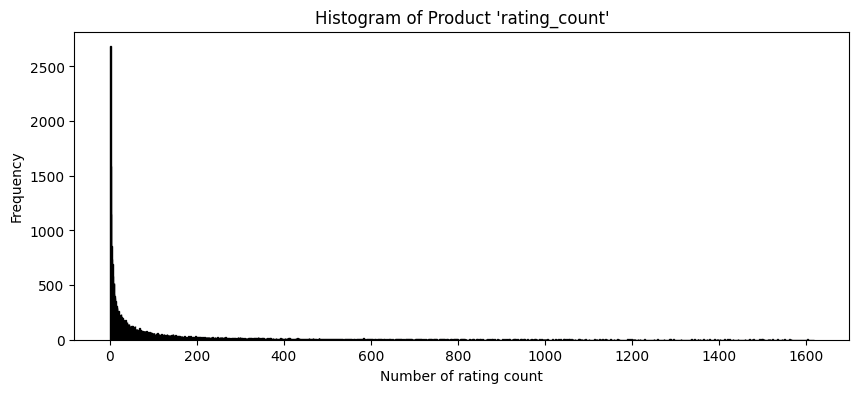

Analysis of the 'review_count' column:
Number of products with value (count): 33542
Mean: 284.25
Standard deviation: 1539.61
Minimum value: 0.0
Maximum value: 61362.0

Relevant percentiles of 'review_count':
  Percentile 1: 0.00
  Percentile 5: 1.00
  Percentile 10: 2.00
  Percentile 25: 6.00
  Percentile 50: 31.00
  Percentile 75: 131.00
  Percentile 90: 495.00
  Percentile 95: 1068.95
  Percentile 99: 3955.13
Concentration ratio (99th percentile / max): 6.45%


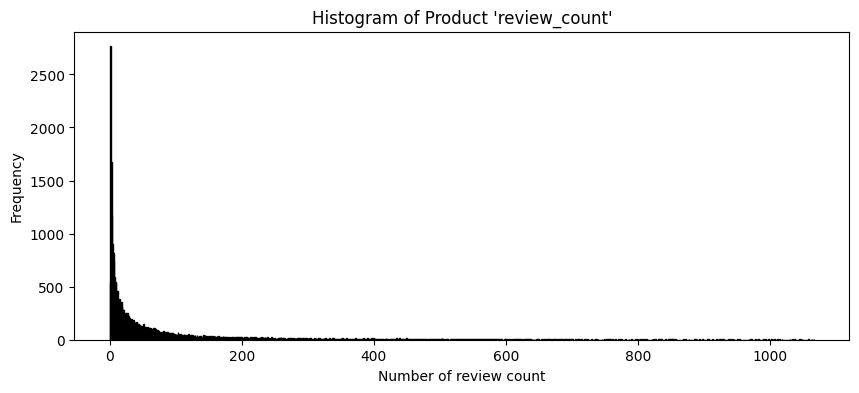

In [38]:
variables = ["rating_count","review_count"]
for variable in variables:  
    analyze_variable(variable, product_df=product_df)

We discarded `rating_count` and `review_count` as features to consider for representing products, since, being numerical characteristics of how often a product is visited or viewed, they don't provide information about the semantic characteristics that describe the object. Therefore, they wouldn't be useful for better matching with the queries. Furthermore, as we've already observed, these two columns are practically zero for most of the data. They are both highly concentrated at zero, so they would provide information about very few products, even if we were interested in including them for the ranking information they represent. Since they don't carry semantic information, one way to include them would be to have the search engine first consider the products with the most views or ranking, but since this is so concentrated, it would discard too many products, so this option is ultimately discarded.

In [39]:
product_df.average_rating.describe()

count    33542.000000
mean         4.530126
std          0.509263
min          1.000000
25%          4.500000
50%          4.500000
75%          5.000000
max          5.000000
Name: average_rating, dtype: float64

In [40]:
sorted(product_df['average_rating'].dropna().unique())

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

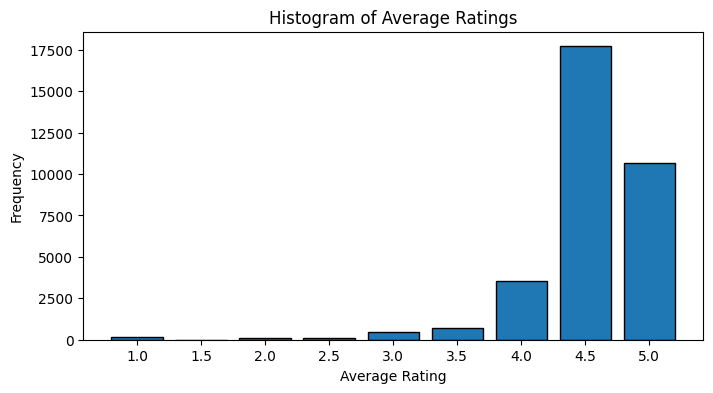

In [41]:
# Create a histogram for average_rating, with bins centered exactly at the values: 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5
centered_ratings = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
# Calculate the bin edges so that they are centered on the above values
# Example: for x=1, left edge=0.75 and right edge=1.25 -> bin width 0.5 centered at 1.0
bin_width = 0.5
bins = [x - bin_width/2 for x in centered_ratings] + [centered_ratings[-1] + bin_width/2]

plt.figure(figsize=(8, 4))
plt.hist(product_df['average_rating'], bins=bins, edgecolor='black', rwidth=0.8)
plt.xticks(centered_ratings)
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Average Ratings")
plt.show()


#The `average_rating` variable appears to be much less concentrated compared with `rating_count` and `review_count`, making it potentially interesting for future analysis or for use in sorting or filtering products. However, for our current task, we are interested in features that describe the semantic content of the product (i.e., what the product actually is), not just metrics of popularity or user engagement. The `average_rating` does not provide semantic information about the product itself; it simply reflects how satisfied users were on average, which could be influenced by many factors unrelated to semantic similarity with a query.
# 
#While it's possible that `average_rating` could be useful for pre- or post-processing steps (such as boosting scores or filtering after semantic matching), it should not strongly influence the core matching step intended to answer "what products most closely match the query?" Therefore, to keep our representation focused on semantic information, we will also remove `average_rating` as a feature for the retrieval model.

In [42]:
# Define columns to remove and transfer
cols_to_remove = ['rating_count', 'review_count', 'average_rating']

# Ensure not_used_columns_of_product_df exists, even if it's the first time we run this cell
not_used_columns_of_product_df = globals().get('not_used_columns_of_product_df', pd.DataFrame())

# Check which columns actually exist in product_df
if product_df is not None:
    # 1) Columns from cols_to_remove that actually exist in product_df
    existing_cols = [col for col in cols_to_remove if col in product_df.columns]
    
    if existing_cols:
        # Copy the columns we are going to remove
        removed_cols_df = product_df[existing_cols].copy()
        # Remove the columns from product_df
        product_df.drop(columns=existing_cols, inplace=True)
        
        # 2) From those removed columns, see which ones are NOT yet in not_used_columns_of_product_df
        new_cols = [col for col in existing_cols if col not in not_used_columns_of_product_df.columns]
        
        # If there are no new columns, we don't touch not_used_columns_of_product_df
        if new_cols:
            cols_to_append = removed_cols_df[new_cols]
            
            if not not_used_columns_of_product_df.empty:
                # Concatenate horizontally only the new columns
                not_used_columns_of_product_df = pd.concat(
                    [not_used_columns_of_product_df, cols_to_append],
                    axis=1
                )
            else:
                # If it's empty, simply assign
                not_used_columns_of_product_df = cols_to_append
        # else: all columns were already saved → we do nothing with not_used_columns_of_product_df

else:
    print("Error: product_df is None. Please ensure it was loaded correctly.")

In [43]:
print(not_used_columns_of_product_df)

       rating_count  review_count  average_rating  \
0              15.0          15.0             4.5   
1             100.0          98.0             2.0   
2             208.0         181.0             3.0   
3              69.0          42.0             4.5   
4              70.0          42.0             5.0   
...             ...           ...             ...   
42989           3.0           2.0             4.5   
42990        1314.0         864.0             4.5   
42991          49.0          41.0             4.0   
42992        1746.0        1226.0             4.5   
42993          20.0          20.0             4.5   

                                                                                                                                                                                                                                                                                                                                                                           

In [44]:
product_df

,product_id,product_name,product_class,category hierarchy,product_description,product_features
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds,"good , deep sleep can be quite difficult to have in this busy age . fortunately , there ’ s an antidote to such a problem : a nice , quality bed frame like the acacia kaylin . solidly constructed from acacia wood , this bed frame will stand the test of time and is fit to rest your shoulders on for years and years . its sleek , natural wood grain appearance provides a pleasant aesthetic to adorn any bedroom , acting both as a decorative piece as well as a place to give comfort after a hard day of work . our bed frame is designed to give ample under-bed space for easy cleaning and other usages , with a headboard attached to further express the craftiness . it can be used with other accessories such as a nightstand or bookcase headboard and is compatible with many types of mattresses including memory foam , spring , or hybrid ones . there ’ s nowhere better to relax than your own home , and with this bed frame that feeling of homeliness will even be more emphasized . rest comfortably and in style .",overallwidth-sidetoside:64.7|dsprimaryproductstyle : modern|countryoforigin-additionaldetails : made in viet nam|headboardtype : slat|headboardheight-toptobedframe:25.35|weightcapacity:500|estimatedtimetosetup:120|overalllength-headtotoe:77.9|levelofassembly : full assembly needed|overallproductweight:78.7|woodspecies : rubberwood|numberofslatsincluded:12|overallheight-toptobottom:39.6|headboardshape : rectangular|woodspecies : acacia|weightcapacity:800|baseconstruction : platform|color : caramel|additionaltoolsrequirednotincluded : all tools included|headboarddepth-fronttoback:0.78|overallwidth-sidetoside:43.3|color : chocolate|warrantylength:5 years|bedtype : other|mattresssize : queen|bedstorageincluded : none|purposefuldistressingtype : wood scoring & rub through|overalllength-headtotoe:83|recommendedmattressthickness:10|overallproductweight:52|mattresssize : twin|overallheightoflegs:14.25|clearancefromfloortoundersideofbed:14|dssecondaryproductstyle : mid-century modern|framematerial : solid wood|dswoodtone : medium wood|minimumrecommendedceilingheight:84|naturalvariationtype : natural wood grain color variation|suggestednumberofpeopleforassemblyinstall:2|californiaproposition65warningrequired : no|lightedheadboard : no|footboard : no|adjustablebed : no|cpsiacompliant : no|adjustableheadboard : no| : no|compositewoodproductcwp : no|centersupportlegs : no|trundlebedincluded : no|nfpacompliant : no|upholstered : no|mattress : no|scscertified : no|cpsc-16cfr1500.48compliant : no|boxspringrequired : no|commercialwarranty : no|built-indesk : no|canopyfabricincluded : no|trundlebed : no|textilelabellingandadvertisingregulationscrcc1551 : no|mattressincluded : no|canadaproductrestriction : no|murphybed : no|compatiblewithadjustablebed : no|footboardincluded : no|waterbedmattressincluded : no|organic : no|iron : no|tvbed : no|drawers : no|gsaapproved : no|installationrequired : no|finishedback : yes|legs : yes|uniformpackagingandlabelingregulationsuplrcompliant : yes|adultassemblyrequired : yes|productwarranty : yes|additionalintendeduseforchild : yes|eligibleforreplacementparts : yes| : yes|headboard : yes|cpsc-16cfr1303compliant : yes|avoidpowertools : yes|generalcertificateofconformitygcc : yes|wood : yes|non-toxic : yes|taacompliant : yes|headboardincluded : yes|fullorlimitedwarranty : limited|supplierintendedandapproveduse : residential use
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers,"create delicious slow-cooked meals , from tender meat to flavorful veggies , with this easy-to-use slow cooker . the unit features a nonstick cast-aluminum insert that moves seamlessly from the oven or stovetop to the electric base to the table . you c

As in the original version, the product ID will be used solely as an ID, and for the text representation of the product, the product name and product description will be concatenated, as this is the baseline for this task. Therefore, we will now analyze how we can represent the remaining not discard columns.

In [45]:
remaining_product_columns = ["product_class", "category hierarchy", "product_features"]

In [46]:
# Display the full text content for each element
pd.set_option('display.max_colwidth', None)
product_df[remaining_product_columns].head(3)

,product_class,category hierarchy,product_features
0,Beds,Furniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds,overallwidth-sidetoside:64.7|dsprimaryproductstyle : modern|countryoforigin-additionaldetails : made in viet nam|headboardtype : slat|headboardheight-toptobedframe:25.35|weightcapacity:500|estimatedtimetosetup:120|overalllength-headtotoe:77.9|levelofassembly : full assembly needed|overallproductweight:78.7|woodspecies : rubberwood|numberofslatsincluded:12|overallheight-toptobottom:39.6|headboardshape : rectangular|woodspecies : acacia|weightcapacity:800|baseconstruction : platform|color : caramel|additionaltoolsrequirednotincluded : all tools included|headboarddepth-fronttoback:0.78|overallwidth-sidetoside:43.3|color : chocolate|warrantylength:5 years|bedtype : other|mattresssize : queen|bedstorageincluded : none|purposefuldistressingtype : wood scoring & rub through|overalllength-headtotoe:83|recommendedmattressthickness:10|overallproductweight:52|mattresssize : twin|overallheightoflegs:14.25|clearancefromfloortoundersideofbed:14|dssecondaryproductstyle : mid-century modern|framematerial : solid wood|dswoodtone : medium wood|minimumrecommendedceilingheight:84|naturalvariationtype : natural wood grain color variation|suggestednumberofpeopleforassemblyinstall:2|californiaproposition65warningrequired : no|lightedheadboard : no|footboard : no|adjustablebed : no|cpsiacompliant : no|adjustableheadboard : no| : no|compositewoodproductcwp : no|centersupportlegs : no|trundlebedincluded : no|nfpacompliant : no|upholstered : no|mattress : no|scscertified : no|cpsc-16cfr1500.48compliant : no|boxspringrequired : no|commercialwarranty : no|built-indesk : no|canopyfabricincluded : no|trundlebed : no|textilelabellingandadvertisingregulationscrcc1551 : no|mattressincluded : no|canadaproductrestriction : no|murphybed : no|compatiblewithadjustablebed : no|footboardincluded : no|waterbedmattressincluded : no|organic : no|iron : no|tvbed : no|drawers : no|gsaapproved : no|installationrequired : no|finishedback : yes|legs : yes|uniformpackagingandlabelingregulationsuplrcompliant : yes|adultassemblyrequired : yes|productwarranty : yes|additionalintendeduseforchild : yes|eligibleforreplacementparts : yes| : yes|headboard : yes|cpsc-16cfr1303compliant : yes|avoidpowertools : yes|generalcertificateofconformitygcc : yes|wood : yes|non-toxic : yes|taacompliant : yes|headboardincluded : yes|fullorlimitedwarranty : limited|supplierintendedandapproveduse : residential use
1,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers,capacityquarts:7|producttype : slow cooker|programmablecookingsettings : slow cook|overallheight-toptobottom:14.2|overalldepth-fronttoback:11.3|programmablefoodsettings : soup|overallwidth-sidetoside:19.9|topprogrammablesettings : soup & stew|programmablecookingsettings : keep warm|dishwashersafeparts : cooking pot/insert|dishwashersafeparts : lid|features : non-stick|housingheatingbasematerial : stainless steel|cookingpotinsertmaterial : aluminum|features : automatic shutoff|operationtype : programmable|finish : white|overallproductweight:13|programmablefoodsettings : stew|features : adjustable temperature settings| : no|uniformpackagingandlabelingregulationsuplrcompliant : no|commercialwarranty : no|indicatorlight : yes|removablecookingpotinsert : yes|programmable : yes|countryoforigin : china|supplierintendedandapproveduse : residential use
2,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers,"features : keep warm setting|capacityquarts:6.5|programmablefoodsettings : soup|warrantylength:1 year| : slow cooker , lid and insert|features : adjustable temperature settings|features : portable|overallproductweight:18|cookedriceyieldcups:26|housingheatingbasematerial : stainless steel|programmablecookingsettings : keep warm|programmablecookingsettings : slow cook|overalldepth-front

# 

In [47]:
# Calculate number of unique values for each remaining product column
print("Number of unique values for each remaining product column:")
unique_counts = product_df[remaining_product_columns].nunique()
print(unique_counts)
print(f"\nTotal number of products in dataset: {len(product_df)}")

# Calculate the ratio of unique product_features to total products
product_features_ratio = (unique_counts['product_features'] / len(product_df)) * 100
print(f"\nProduct features uniqueness ratio: {product_features_ratio:.2f}%")
print(f"This means that product_features has {unique_counts['product_features']} unique values out of {len(product_df)} total products.")
print("This high ratio indicates that product_features is a variable with too many possible values,")
print("making it potentially problematic for text representation due to its high cardinality.")



Number of unique values for each remaining product column:
product_class           860
category hierarchy     1623
product_features      42979
dtype: int64

Total number of products in dataset: 42994

Product features uniqueness ratio: 99.97%
This means that product_features has 42979 unique values out of 42994 total products.
This high ratio indicates that product_features is a variable with too many possible values,
making it potentially problematic for text representation due to its high cardinality.


A simple visual analysis reveals that the `product_features` column exhibits excessive diversity, with inconsistent elements and lengths across products. Each product has its own list of features with its own values, making its representation extremely difficult. Furthermore, its excessive length compared to the `product_description` column could overshadow it. It's worth noting that, from an information theory perspective, variables capable of having too many meanings are considered uninformative. Therefore, just as a column with only identical values ​​(i.e., with a single possible value) is uninformative, so too is a column with too many possible values, or even one where each row has a different value. With practically as many possible values ​​as rows, a probability distribution estimate would yield something quite close to a uniform distribution. From information theory, we know that given a certain domain, this is the distribution that minimizes entropy, making it the least informative and contributing the least to the product's representation. It is for all these reasons that we also discard the `product_description` column.

In [48]:
# Concatenate the product_features column to not_used_columns_of_product_df and delete it from product_df
# If product_features is in product_df then copy it to a new variable and remove it from product_df
if 'product_features' in product_df.columns:
    product_features_df = product_df['product_features'].copy()
    product_df.drop(columns=['product_features'], inplace=True)

    # If the column is not in not_used_columns_of_product_df, we add it
    if 'product_features' not in not_used_columns_of_product_df.columns:
        not_used_columns_of_product_df = pd.concat([not_used_columns_of_product_df, product_features_df], axis=1)


# So, the product_df to represent is the next,

In [49]:
product_df

,product_id,product_name,product_class,category hierarchy,product_description
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds,"good , deep sleep can be quite difficult to have in this busy age . fortunately , there ’ s an antidote to such a problem : a nice , quality bed frame like the acacia kaylin . solidly constructed from acacia wood , this bed frame will stand the test of time and is fit to rest your shoulders on for years and years . its sleek , natural wood grain appearance provides a pleasant aesthetic to adorn any bedroom , acting both as a decorative piece as well as a place to give comfort after a hard day of work . our bed frame is designed to give ample under-bed space for easy cleaning and other usages , with a headboard attached to further express the craftiness . it can be used with other accessories such as a nightstand or bookcase headboard and is compatible with many types of mattresses including memory foam , spring , or hybrid ones . there ’ s nowhere better to relax than your own home , and with this bed frame that feeling of homeliness will even be more emphasized . rest comfortably and in style ."
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers,"create delicious slow-cooked meals , from tender meat to flavorful veggies , with this easy-to-use slow cooker . the unit features a nonstick cast-aluminum insert that moves seamlessly from the oven or stovetop to the electric base to the table . you can use the insert alone or with the slow cooker to make a variety of one-pot dishes from soup to desserts , and much more . you can even prepare your ingredients in the morning , place everything in the slow cooker , and walk away to come home to the aroma of a hot , healthy dinner at the end of a busy day . with its sleek stainless-steel finish , the slow cooker not only presents beautifully , but it ’ s also the perfect size to accommodate the whole family or a large group when entertaining ."
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers,"prepare home-cooked meals on any schedule with this essential slow cooker , featuring a dishwasher-safe insert and 26-hour timer ."
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,"this original stainless tool was designed to complement manufacturer 's cookware . the pizza cutter features a sharp rotary blade to easily cut through pizza crust , pasta dough and pastries ."
4,4,baldwin prestige alcott passage knob with round rosette,Door Knobs,Home Improvement / Doors & Door Hardware / Door Hardware & Accessories / Door Knobs / Round Door Knobs,"the hardware has a rich heritage of delivering modern luxury to discriminating homeowners . this offers effortless , accessible style and luxury . any homeowner can instantly create an atmosphere of confidence from the moment someone knocks on the door . the baldwin prestige alcott passage knob with round rosette features a classic-round traditional inspired design which is offered in keyed-entry , passage , privacy , and half dummy functions ."
...,...,...,...,...,...
42989,42989,malibu pressure balanced diverter fixed shower head shower panel,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom Fixtures / Showers & Bathtubs / Showers & Bathtubs Plumbing / Shower Panels / Wall Mounted Shower Panels,"the malibu pressure balanced diverter fixed shower head shower panel is stylish , contemporary , and sleek ! chrome fixtures compliment the beautiful stainless steel panel . this unit includes 2 oversized single-function body sprays , a sleek hand shower , and a rain showerhead . easily turn any shower into an oasis with the malibu pressure balanced diverter fixed shower head shower panel ."
42990,42990,em

Let analize the remaining columns 

In [50]:
remaining_product_columns_2 = ["product_class", "category hierarchy"]
product_df[remaining_product_columns_2]

,product_class,category hierarchy
0,Beds,Furniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds
1,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers
2,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Slow Cookers / Slow Slow Cookers
3,"Slicers, Peelers And Graters",Browse By Brand / All-Clad
4,Door Knobs,Home Improvement / Doors & Door Hardware / Door Hardware & Accessories / Door Knobs / Round Door Knobs
...,...,...
42989,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom Fixtures / Showers & Bathtubs / Showers & Bathtubs Plumbing / Shower Panels / Wall Mounted Shower Panels
42990,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dining Tables & Seating / Kitchen and Dining Sets
42991,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dining Tables & Seating / Kitchen and Dining Sets
42992,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & Seating / Accent Chairs


In [51]:
product_class_df = product_df["product_class"]
category_hierarchy_df = product_df["category hierarchy"]

# Important: We cleared the two categorical columns to be included in the product representation of Nan and null values.

In [52]:
#clean
print("=" * 80)
print("DATA CLEANING: Checking for missing values")
print("=" * 80)

# Check for missing values in both columns
print(f"Missing values in product_class: {product_df['product_class'].isna().sum()}")
print(f"Missing values in category hierarchy: {product_df['category hierarchy'].isna().sum()}")

# Fill missing values with a placeholder string "UNKNOWN"
if product_df['product_class'].isna().any():
    print("\nFilling missing values in product_class with 'UNKNOWN'")
    product_df['product_class'] = product_df['product_class'].fillna('UNKNOWN')

if product_df['category hierarchy'].isna().any():
    print("Filling missing values in category hierarchy with 'UNKNOWN'")
    product_df['category hierarchy'] = product_df['category hierarchy'].fillna('UNKNOWN')


DATA CLEANING: Checking for missing values
Missing values in product_class: 2852
Missing values in category hierarchy: 1556

Filling missing values in product_class with 'UNKNOWN'
Filling missing values in category hierarchy with 'UNKNOWN'


In [53]:
# Calculate entropy for product_class_df
print("Analysis of product_class column:")
product_class_unique_values = product_class_df.nunique()
print(f"Number of unique values: {product_class_unique_values}")

# Calculate frequency distribution
product_class_value_counts = product_class_df.value_counts()
product_class_probabilities = product_class_value_counts / len(product_class_df)

# Calculate entropy
product_class_entropy = -sum(p * np.log2(p) for p in product_class_probabilities if p > 0)
print(f"Entropy: {product_class_entropy:.4f} bits")

# Calculate entropy for category_hierarchy_df
print("Analysis of category_hierarchy column:")
category_hierarchy_unique_values = category_hierarchy_df.nunique()
print(f"Number of unique values: {category_hierarchy_unique_values}")

# Calculate frequency distribution
category_hierarchy_value_counts = category_hierarchy_df.value_counts()
category_hierarchy_probabilities = category_hierarchy_value_counts / len(category_hierarchy_df)

# Calculate entropy
category_hierarchy_entropy = -sum(p * np.log2(p) for p in category_hierarchy_probabilities if p > 0)
print(f"Entropy: {category_hierarchy_entropy:.4f} bits")


Analysis of product_class column:
Number of unique values: 860
Entropy: 7.2205 bits
Analysis of category_hierarchy column:
Number of unique values: 1623
Entropy: 8.0703 bits


Since both entropy values ​​are close to 8 bits, for simplicity we will consider them both as 8. Therefore, from information theory, we know that each of these two columns can be compressed to its maximum entropy by Shannon's theorem. That is, the most compact way to represent each value is an array of 8 values ​​that are either 1 or 0. This is the maximum compression we can apply without losing information. Now, it is trivial to observe that the information contained in an array of 8 float values ​​between 0 and 1 or between -1 and 1, and in general, an array of 8 elements with floating-point values, contains the same information and more. Therefore, we can conclude that a representation of an array of 8 floating-point values ​​would be more than sufficient to represent each of these two columns.

In [54]:
# Convert product_class and category hierarchy to 8 floating-point values each using MCA
# Since the variables to decompose are categorical, we use MCA from the prince library 
# which is an extension of PCA for categorical variables
# We apply MCA separately to each column to get 8 components from each

print("\n" + "=" * 80)
print("TRANSFORMING product_class COLUMN")
print("=" * 80)

# Transform product_class: 1 categorical column -> 8 numerical components
mca_product_class = prince.MCA(n_components=8)
mca_product_class_result = mca_product_class.fit(product_df[['product_class']])
transformed_product_class = mca_product_class_result.transform(product_df[['product_class']])

# Create column names for product_class components
product_class_columns = [f'product_class_mca_{i+1}' for i in range(8)]
product_df[product_class_columns] = transformed_product_class

print(f"\nOriginal product_class unique values: {product_df['product_class'].nunique()}")
print(f"Transformed to {len(product_class_columns)} MCA components")
print("\nFirst 5 rows of product_class MCA components:")
print(product_df[product_class_columns].head())

print("\n" + "=" * 80)
print("TRANSFORMING category hierarchy COLUMN")
print("=" * 80)

# Transform category hierarchy: 1 categorical column -> 8 numerical components
mca_category = prince.MCA(n_components=8)
mca_category_result = mca_category.fit(product_df[['category hierarchy']])
transformed_category = mca_category_result.transform(product_df[['category hierarchy']])

# Create column names for category hierarchy components
category_columns = [f'category_hierarchy_mca_{i+1}' for i in range(8)]
product_df[category_columns] = transformed_category

print(f"\nOriginal category hierarchy unique values: {product_df['category hierarchy'].nunique()}")
print(f"Transformed to {len(category_columns)} MCA components")
print("\nFirst 5 rows of category hierarchy MCA components:")
print(product_df[category_columns].head())

print("\n" + "=" * 80)
print("FINAL REPRESENTATION")
print("=" * 80)

# Show both transformations together
all_mca_columns = product_class_columns + category_columns
print(f"\nTotal MCA components created: {len(all_mca_columns)} (8 from product_class + 8 from category hierarchy)")
print("\nFirst 5 products with all MCA components:")
print(product_df[all_mca_columns].head())

# Print each row as arrays for the first 5 products
print("\n" + "=" * 80)
print("SAMPLE: First 5 products as 8-element vectors")
print("=" * 80)
for i in range(min(5, len(product_df))):
    product_class_vector = product_df[product_class_columns].iloc[i].values
    category_vector = product_df[category_columns].iloc[i].values
    print(f"\nProduct {i}:")
    print(f"  product_class vector (8 elements): {product_class_vector}")
    print(f"  category hierarchy vector (8 elements): {category_vector}")

# Remove the original categorical columns since they are now represented by MCA components
print("\n" + "=" * 80)
print("Removing original categorical columns...")
product_df.drop(columns=['product_class', 'category hierarchy'], inplace=True)
print("Done! Original categorical columns removed from product_df")
print(f"\nFinal product_df shape: {product_df.shape}")
print(f"Columns: {list(product_df.columns)}")




TRANSFORMING product_class COLUMN



Original product_class unique values: 861
Transformed to 8 MCA components

First 5 rows of product_class MCA components:
   product_class_mca_1  product_class_mca_2  product_class_mca_3  \
0             0.116129             0.105033             0.127068   
1            -0.374288            -0.367900            -0.571766   
2            -0.374288            -0.367900            -0.571766   
3             3.201144            -5.185621             5.822033   
4             1.651889             0.276602             1.463822   

   product_class_mca_4  product_class_mca_5  product_class_mca_6  \
0             0.084177            -0.269035             0.027013   
1            -0.512919            -0.657817             0.729077   
2            -0.512919            -0.657817             0.729077   
3            -4.004622            -4.243570             0.561276   
4             0.991339            -1.062973             0.232461   

   product_class_mca_7  product_class_mca_8  
0            -

In [55]:
# Check the min and max values of each MCA component column
print("=" * 80)
print("MCA COMPONENTS VALUE RANGES")
print("=" * 80)

print("\nProduct Class MCA Components (8 components):")
for col in product_class_columns:
    min_val = product_df[col].min()
    max_val = product_df[col].max()
    print(f"  {col}: min = {min_val:.6f}, max = {max_val:.6f}")

print("\nCategory Hierarchy MCA Components (8 components):")
for col in category_columns:
    min_val = product_df[col].min()
    max_val = product_df[col].max()
    print(f"  {col}: min = {min_val:.6f}, max = {max_val:.6f}")

print("\nSummary statistics for all MCA components:")
print(product_df[all_mca_columns].describe())


MCA COMPONENTS VALUE RANGES

Product Class MCA Components (8 components):
  product_class_mca_1: min = -20.016846, max = 22.042809
  product_class_mca_2: min = -18.440969, max = 30.721610
  product_class_mca_3: min = -17.891633, max = 21.297278
  product_class_mca_4: min = -16.281330, max = 18.874239
  product_class_mca_5: min = -15.331800, max = 19.073611
  product_class_mca_6: min = -14.841128, max = 18.211263
  product_class_mca_7: min = -21.343623, max = 21.528021
  product_class_mca_8: min = -19.150412, max = 19.896225

Category Hierarchy MCA Components (8 components):
  category_hierarchy_mca_1: min = -15.257483, max = 15.273000
  category_hierarchy_mca_2: min = -15.827341, max = 18.137227
  category_hierarchy_mca_3: min = -13.645939, max = 17.017401
  category_hierarchy_mca_4: min = -14.293378, max = 17.987197
  category_hierarchy_mca_5: min = -11.883885, max = 18.931067
  category_hierarchy_mca_6: min = -15.197156, max = 15.608465
  category_hierarchy_mca_7: min = -14.482179, m

In [56]:
print(f"Columns: {list(product_df.columns)}")

Columns: ['product_id', 'product_name', 'product_description', 'product_class_mca_1', 'product_class_mca_2', 'product_class_mca_3', 'product_class_mca_4', 'product_class_mca_5', 'product_class_mca_6', 'product_class_mca_7', 'product_class_mca_8', 'category_hierarchy_mca_1', 'category_hierarchy_mca_2', 'category_hierarchy_mca_3', 'category_hierarchy_mca_4', 'category_hierarchy_mca_5', 'category_hierarchy_mca_6', 'category_hierarchy_mca_7', 'category_hierarchy_mca_8']


# Continue the assignment

In [57]:
# get search queries
query_df = pd.read_csv("WANDS/dataset/query.csv", sep='\t')
query_df.head()

,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor
3,3,turquoise pillows,Accent Pillows
4,4,chair and a half recliner,Recliners


In [58]:
# get manually labeled groundtruth lables
label_df = pd.read_csv("WANDS/dataset/label.csv", sep='\t')
label_df.head()

,id,query_id,product_id,label
0,0,0,25434,Exact
1,1,0,12088,Irrelevant
2,2,0,42931,Exact
3,3,0,2636,Exact
4,4,0,42923,Exact


In [59]:
#define functions for product search using Tf-IDF
def calculate_tfidf(dataframe):
    """
    Calculate the TF-IDF for combined product name and description.

    Parameters:
    dataframe (pd.DataFrame): DataFrame with product_id, and other product information.

    Returns:
    TfidfVectorizer, csr_matrix: TF-IDF vectorizer and TF-IDF matrix.
    """
    # Combine product name and description to vectorize
    # NOTE: Please feel free to use any combination of columns available, some columns may contain NULL values
    combined_text = dataframe['product_name'] + ' ' + dataframe['product_description']
    vectorizer = TfidfVectorizer()
    # convert combined_text to list of unicode strings
    tfidf_matrix = vectorizer.fit_transform(combined_text.values.astype('U'))
    return vectorizer, tfidf_matrix

def get_top_products(vectorizer, tfidf_matrix, query, top_n=10):
    """
    Get top N products for a given query based on TF-IDF similarity.

    Parameters:
    vectorizer (TfidfVectorizer): Trained TF-IDF vectorizer.
    tfidf_matrix (csr_matrix): TF-IDF matrix for the products.
    query (str): Search query.
    top_n (int): Number of top products to return.

    Returns:
    list: List of top N product IDs.
    """
    query_vector = vectorizer.transform([query])
    cosine_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_product_indices = cosine_similarities.argsort()[-top_n:][::-1]
    return top_product_indices

In [60]:
# Calculate TF-IDF
vectorizer, tfidf_matrix = calculate_tfidf(product_df)

In [61]:
print(tfidf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2165515 stored elements and shape (42994, 44307)>
  Coords	Values
  (0, 37359)	0.04286369943700525
  (0, 43583)	0.11491693346949185
  (0, 31640)	0.06713856059464626
  (0, 6001)	0.31112254761716074
  (0, 19267)	0.06399940795284022
  (0, 12795)	0.07409628224778292
  (0, 36969)	0.0701131605670505
  (0, 8584)	0.07406454291642427
  (0, 5895)	0.12075714933060729
  (0, 32933)	0.10366305351857981
  (0, 13471)	0.11985654642423552
  (0, 40362)	0.1619522065415131
  (0, 20495)	0.04968889175578988
  (0, 21930)	0.047322942615967006
  (0, 40054)	0.06106651260756289
  (0, 8206)	0.09318259431790867
  (0, 2545)	0.09659627461041606
  (0, 17928)	0.1564081313942533
  (0, 39968)	0.13105006591527432
  (0, 3634)	0.03351282549061008
  (0, 3975)	0.1433506110007575
  (0, 38793)	0.13979523588185486
  (0, 32427)	0.09956346547603899
  (0, 29038)	0.0886675129382131
  (0, 32827)	0.04726514556600696
  :	:
  (42993, 733)	0.10044062538615821
  (42993, 22081)	

Let's analyze the original representation of the products, that is, the tfidf of each product calculated from the product name and description columns. This 2 columns are translate to 44307 columns by tdidf, so let analyze if we can compress this with clasical TruncatedSVD 

# 44307 = 547 * 27 * 3

In [ ]:
# Perform TruncatedSVD with different numbers of principal components and analyze explained variance ratio
# Using the elbow method to determine the optimal number of components
# Testing components from 547 to 14769(=27*547) in steps of 547 (27*547 = 14769)

from sklearn.decomposition import TruncatedSVD

# Use TruncatedSVD instead of PCA for sparse matrices - much faster and memory efficient
# TruncatedSVD works directly with sparse matrices without converting to dense

# Define range of components to test (547 steps up to 14769)
max_components = min(tfidf_matrix.shape[0], tfidf_matrix.shape[1]) - 1  # TruncatedSVD requires n_components < min dimension
component_range = range(547, min(max_components, 14769) + 1, 547)

explained_variance_ratios = []
cumulative_variance_ratios = []
n_components_list = []

print("Testing TruncatedSVD with different numbers of components...")
print(f"Matrix shape: {tfidf_matrix.shape}")
print(f"Testing from 547 to {min(max_components, 14769)} in steps of 547")

for n_components in component_range:
    if n_components >= max_components:
        break
    print(f"Testing {n_components} components...")
    
    # TruncatedSVD is optimized for sparse matrices
    svd = TruncatedSVD(n_components=n_components, random_state=42, algorithm='randomized')
    svd.fit(tfidf_matrix)
    
    cumulative_var = svd.explained_variance_ratio_.sum()
    explained_variance_ratios.append(cumulative_var)
    cumulative_variance_ratios.append(cumulative_var)
    n_components_list.append(n_components)
    
    # Early stopping if we reach 99% variance
    if cumulative_var >= 0.99:
        print(f"Reached 99% variance at {n_components} components. Stopping early.")
        break

# Create visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Explained Variance Ratio vs Number of Components
axes[0].plot(n_components_list, explained_variance_ratios, 'b-o', linewidth=2, markersize=4)
axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('Cumulative Explained Variance Ratio', fontsize=12)
axes[0].set_title('TruncatedSVD: Cumulative Explained Variance vs Number of Components', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
axes[0].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance Threshold')
axes[0].legend()

# Plot 2: Elbow Method - Rate of Change
if len(n_components_list) > 1:
    variance_diff = np.diff(explained_variance_ratios)
    axes[1].plot(n_components_list[1:], variance_diff, 'g-o', linewidth=2, markersize=4)
    axes[1].set_xlabel('Number of Components', fontsize=12)
    axes[1].set_ylabel('Incremental Explained Variance', fontsize=12)
    axes[1].set_title('TruncatedSVD: Incremental Variance Gain (Elbow Detection)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("TruncatedSVD Analysis Summary")
print("="*60)
for i, n_comp in enumerate(n_components_list):
    print(f"Components: {n_comp:5d} | Cumulative Variance: {explained_variance_ratios[i]:.4f}")
    if explained_variance_ratios[i] >= 0.90 and (i == 0 or explained_variance_ratios[i-1] < 0.90):
        print(f"  --> 90% variance threshold reached at {n_comp} components")
    if explained_variance_ratios[i] >= 0.95 and (i == 0 or explained_variance_ratios[i-1] < 0.95):
        print(f"  --> 95% variance threshold reached at {n_comp} components")

Testing TruncatedSVD with different numbers of components...
Matrix shape: (42994, 44307)
Testing from 547 to 14769 in steps of 547
Testing 547 components...
Testing 1094 components...


In [ ]:
#define functions for evaluating retrieval performance
def map_at_k(true_ids, predicted_ids, k=10):
    """
    Calculate the Mean Average Precision at K (MAP@K).

    Parameters:
    true_ids (list): List of relevant product IDs.
    predicted_ids (list): List of predicted product IDs.
    k (int): Number of top elements to consider.
             NOTE: IF you wish to change top k, please provide a justification for choosing the new value

    Returns:
    float: MAP@K score.
    """
    #if either list is empty, return 0
    if not len(true_ids) or not len(predicted_ids):
        return 0.0

    score = 0.0
    num_hits = 0.0

    for i, p_id in enumerate(predicted_ids[:k]):
        if p_id in true_ids and p_id not in predicted_ids[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(true_ids), k)

In [ ]:
# Please add any new evaluation functions here

In [ ]:
#Sanity check code block to see if the search results are relevant
#implementing a function to retrieve top K product IDs for a query
def get_top_product_ids_for_query(query):
    top_product_indices = get_top_products(vectorizer, tfidf_matrix, query, top_n=10)
    top_product_ids = product_df.iloc[top_product_indices]['product_id'].tolist()
    return top_product_ids

#define the test query
query = "armchair"

#obtain top product IDs
top_product_ids = get_top_product_ids_for_query(query)

print(f"Top products for '{query}':")
for product_id in top_product_ids:
    product = product_df.loc[product_df['product_id'] == product_id]
    print(product_id, product['product_name'].values[0])

Top products for 'armchair':
12756 24.41 '' wide tufted polyester armchair
42698 donham armchair
42697 donham 25 '' wide armchair
41270 almaraz 33.7 '' wide leather match armchair
23907 faizah 27.6 '' wide tufted polyester armchair
31564 biloxi 34.75 '' wide armchair
41306 hartsell 33 '' wide armchair
1527 howington 39 '' wide tufted linen armchair
42802 donham polyester lounge chair
6532 ogan 29 '' wide polyester armchair


In [ ]:
#group the labels for each query to use when identifying exact matches
grouped_label_df = label_df.groupby('query_id')

In [ ]:
#implementing a function to retrieve exact match product IDs for a query_id
def get_exact_matches_for_query(query_id):
    query_group = grouped_label_df.get_group(query_id)
    exact_matches = query_group.loc[query_group['label'] == 'Exact']['product_id'].values
    return exact_matches

#applying the function to obtain top product IDs and adding top K product IDs to the dataframe 
query_df['top_product_ids'] = query_df['query'].apply(get_top_product_ids_for_query)

#adding the list of exact match product_IDs from labels_df
query_df['relevant_ids'] = query_df['query_id'].apply(get_exact_matches_for_query)

#now assign the map@k score
query_df['map@k'] = query_df.apply(lambda x: map_at_k(x['relevant_ids'], x['top_product_ids'], k=10), axis=1)


KeyboardInterrupt: 

In [ ]:
# calculate the MAP across the entire query set
query_df.loc[:, 'map@k'].mean()

0.29319550540123457